In [ ]:
# default_exp

In [ ]:
#hide
#all_slow

# 1-D prior toy example

> Demonstration of prior error bounds for a 1-D toy example

In this notebook we will demonstrate the error bounds for the statFEM prior for the toy example introduced in <a href="/statFEM/oneDim.html#1-dimensional-case-(ODE)"><code>oneDim</code></a>. We first import some required packages.

In [ ]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)
# import required functions from oneDim
from statFEM.oneDim import mean_assembler, kernMat, cov_assembler
from scipy.stats import linregress
from scipy import integrate
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
import sympy; sympy.init_printing()
# code for displaying matrices nicely
def display_matrix(m):
    display(sympy.Matrix(m))

The random forcing term has the following GP distribution:

$$f\sim\mathcal{GP}(\bar{f},k_{f})$$

where,

$$\bar{f}(x)=1$$
$$k_{f}(x,y)=\sigma_{f}^{2}\exp\left(-\frac{|x-y|^{2}}{2l_{f}^{2}}\right)$$
$$\sigma_{f}=0.1$$
$$l_{f}=0.4$$

This forcing gives rise to the true solution mean and covariance functions:

$$\mu_{\star}(x)=\frac{1}{2}x(1-x)$$
$$c_{u}(x,y)=\int_{0}^{1}\int_{0}^{1}G(x,w)k_{f}(w,t)G(t,y)dtdw$$

where $G(x,y)$ is the Green's function for our problem:

$$G(x,y)=x(1-y)\Theta(y-x)+(1-x)y\Theta(x-y) \quad \forall x,y\in[0,1]$$

(note: $\Theta(x)$ is the Heaviside Step function). We now set up all these functions, noting that we use quadrature to compute $c_u$.

In [ ]:
# set up true mean and f_bar
μ_star = Expression('0.5*x[0]*(1-x[0])',degree=2)
f_bar = Constant(1.0)

In [ ]:
# set up kernel functions for forcing f
l_f = 0.4
σ_f = 0.1

def c_f(x,y):
    return (σ_f**2)*np.exp(-(x-y)**2/(2*(l_f**2)))

# translation invariant form of c_f
def k_f(x):
    return (σ_f**2)*np.exp(-(x**2)/(2*(l_f**2)))

In [ ]:
# set up true cov function for solution
# compute inner integral over t
def η(w,y):
    I_1 = integrate.quad(lambda t: t*c_f(w,t),0.0,y)[0]
    I_2 = integrate.quad(lambda t: (1-t)*c_f(w,t),y,1.0)[0]
    return (1-y)*I_1 + y*I_2

# use this function eta and compute the outer integral over w
def c_u(x,y):
    I_1 = integrate.quad(lambda w: (1-w)*η(w,y),x,1.0)[0]
    I_2 = integrate.quad(lambda w: w*η(w,y),0.0,x)[0]
    return x*I_1 + (1-x)*I_2

We now set up a reference grid on which we will compare the true and statFEM covariance functions. We take a grid of length $N=51$

In [ ]:
# set up reference grid
N = 51
grid = np.linspace(0,1,N)

We now compute the true prior covariance on this reference grid.

In [ ]:
# get the true cov matrix and its square root
C_true = kernMat(c_u,grid,True,False)
tol = 1e-15
C_true_sqrt = np.real(sqrtm(C_true))
rel_error = np.linalg.norm(C_true_sqrt @ C_true_sqrt - C_true)/np.linalg.norm(C_true)
assert rel_error <= tol

We now set up a function to get the statFEM prior, for a FE mesh size $h$, using functions from <a href="/statFEM/oneDim.html#"><code>oneDim</code></a>.

In [ ]:
# set up function to compute fem_prior
def fem_prior(h,f_bar,k_f,grid):
    J = int(np.round(1/h))
    μ = mean_assembler(h,f_bar)
    Σ = cov_assembler(J,k_f,grid,False,True)
    return μ,Σ

We now set up a function to compare the covariance functions on the reference grid. This function computes an approximation of the covariance contribution to the 2-Wasserstein distance discussed in <a href="/statFEM/oneDim.html#Difference-between-true-prior-covariance-and-statFEM-prior-covariance"><code>oneDim</code></a>.

In [ ]:
# function to compute cov error needed for the approximate wasserstein
def compute_cov_diff(C1,C_true,C_true_sqrt,tol=1e-10):
    N = C_true.shape[0]
    C12 = C_true_sqrt @ C1 @ C_true_sqrt
    C12_sqrt = np.real(sqrtm(C12))
    rel_error = np.linalg.norm(C12_sqrt @ C12_sqrt - C12)/np.linalg.norm(C12)
    assert rel_error < tol
    h = 1/(N-1)
    return h*(np.trace(C_true) + np.trace(C1) - 2*np.trace(C12_sqrt))

With all of this in place we can now set up a function which computes an approximation of the 2-Wasserstein distance between the true and statFEM priors.

In [ ]:
def W(μ_fem,μ_true,Σ_fem,Σ_true,Σ_true_sqrt):
    mean_error = errornorm(μ_true,μ_fem,'L2')
    cov_error = compute_cov_diff(Σ_fem,Σ_true,Σ_true_sqrt)
    cov_error = np.sqrt(np.abs(cov_error))
    error = mean_error + cov_error
    return error

We set up a range of $h$ values on which to compute this error.

In [ ]:
# set up range of h values to use
h_range_tmp = np.linspace(0.25,0.02,100)
h_range = 1/np.unique(np.round(1/h_range_tmp))
np.round(h_range,2)

array([0.25, 0.2 , 0.17, 0.14, 0.12, 0.11, 0.1 , 0.09, 0.08, 0.08, 0.07,
       0.07, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05, 0.05, 0.04, 0.04, 0.04,
       0.04, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02])

We now compute the errors for this range of $h$.

In [ ]:
%%time
errors = []
for h in tqdm(h_range):
    # obtain the fem prior for this value of h
    μ, Σ = fem_prior(h,f_bar,k_f,grid)
    # compute the error between the true and fem prior
    error = W(μ,μ_star,Σ,C_true,C_true_sqrt)
    # append to errors
    errors.append(error)

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 1.61 s, sys: 3.82 s, total: 5.43 s
Wall time: 841 ms


We now analyse the results by plotting the errors on a log-log scale and using ordinary least squares regression to estimate the slope of the line of best fit. This gives us an estimate of the rate of convergence as if we assume:

$$W(\nu_{\star},\nu_{h})\leq\mathcal{O}(h^{p})\text{ as }h\rightarrow 0$$

then we have 

$$W(\nu_{\star},\nu_{h})=Ch^{p}+\mathcal{O}(h^{p+1})$$ 

from which it follows that:

$$\log W(\nu_{\star},\nu_{h})=p\log h + \log|C| + \mathcal{O}(h)$$

and so the slope is the rate of convergence $p$. Our theory gives us $p=2$ and so we should expect to obtain a slope of $2$.

In [ ]:
#hide
errors = np.array(errors)

slope: 2.000352    intercept: -2.185387    r value: 0.999883     p value: 0.000000


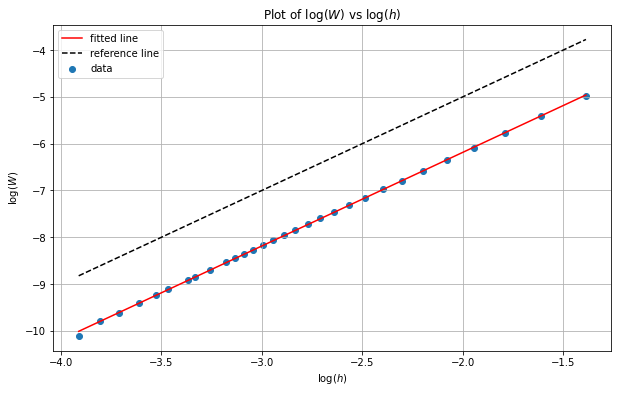

In [ ]:
#hide_input
log_h_range = np.log(h_range)
log_errors = np.log(errors)

# perform linear regression to get line of best fit for the log scales:
lm = linregress(log_h_range,log_errors)
print("slope: %f    intercept: %f    r value: %f     p value: %f" % (lm.slope, lm.intercept, lm.rvalue, lm.pvalue))

# plot line of best fit with the data:
x = np.linspace(np.min(log_h_range),np.max(log_h_range),100)
plt.scatter(log_h_range,log_errors,label='data')
plt.plot(x,lm.intercept + lm.slope * x, 'r', label='fitted line')
plt.plot(x,-1+2*x,'--',c='black',label='reference line')
plt.grid()
plt.legend()
plt.xlabel('$\log(h)$')
plt.ylabel('$\log(W)$')
plt.title('Plot of $\log(W)$ vs $\log(h)$')
plt.savefig('1D_prior_results.png',dpi=300,bbox_inches='tight',facecolor="w")
plt.show()

We can see from the results above that we indeed obtain a slope of $p=2$ for this example.